<a href="https://colab.research.google.com/github/johanjun/dacon_growthperiod/blob/main/training1215(fliped).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from tqdm import tqdm

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [ ]:
root_dir = '/content/drive/MyDrive/dacon_growthperiod/open'
train_data_dir = os.path.join(root_dir, 'train_dataset')
test_data_dir = os.path.join(root_dir, 'test_dataset')

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
train_dir = os.path.join(train_data_dir, 'train')
val_dir = os.path.join(train_data_dir, 'validation')

tfr_dir = os.path.join(train_data_dir, 'tfrecord')

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [ ]:
n_train = 26302
n_val = 1462

In [ ]:
N_EPOCHS = 40
N_BATCH = 200
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'delta': tf.io.FixedLenFeature([], tf.string),
              'time_delta': tf.io.FixedLenFeature([], tf.int64)         
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    delta = tf.io.decode_raw(parsed_features['delta'], tf.uint8)    
    delta = tf.reshape(delta, [IMG_SIZE, IMG_SIZE, 3])
    delta = tf.cast(delta, tf.float32)/255.

    time_delta = tf.cast(parsed_features['time_delta'], tf.int64)

    return delta, time_delta

In [ ]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [ ]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [ ]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  return model

In [ ]:
# # Sequential API를 사용하여 model 구성
# def create_model():
#     model = keras.Sequential()
#     model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
#                                   input_shape=(IMG_SIZE, IMG_SIZE, 3)))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPool2D(padding='SAME'))
#     model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPool2D(padding='SAME'))
#     model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPool2D(padding='SAME'))
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(256, activation='relu'))
#     model.add(keras.layers.Dropout(0.4))
#     model.add(keras.layers.Dense(10, activation='relu'))
#     model.add(Dense(1))
#     return model

In [ ]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='mse',
              metrics=['mse'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/40
131/131 [==============================] - 169s 993ms/step - loss: 42.2984 - mse: 42.2984 - val_loss: 50.8808 - val_mse: 50.8808
Epoch 2/40
131/131 [==============================] - 163s 985ms/step - loss: 2.5982 - mse: 2.5982 - val_loss: 41.4188 - val_mse: 41.4188
Epoch 3/40
131/131 [==============================] - 155s 993ms/step - loss: 1.6523 - mse: 1.6523 - val_loss: 32.6590 - val_mse: 32.6590
Epoch 4/40
131/131 [==============================] - 153s 1s/step - loss: 1.3922 - mse: 1.3922 - val_loss: 24.4265 - val_mse: 24.4265
Epoch 5/40
131/131 [==============================] - 147s 996ms/step - loss: 1.0916 - mse: 1.0916 - val_loss: 17.8451 - val_mse: 17.8451
Epoch 6/40
131/131 [==============================] - 145s 986ms/step - loss: 0.7999 - mse: 0.7999 - val_loss: 13.9701 - val_mse: 13.9701
Epoch 7/40
131/131 [==============================] - 146s 996ms/step - loss: 0.7066 - mse: 0.7066 - val_loss: 9.8614 - val_mse: 9.8614
Epoch 8/40
131/131 [=================

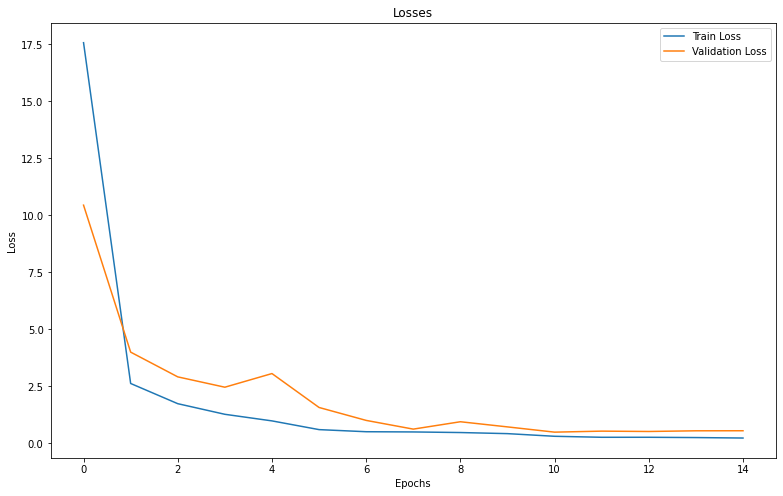

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

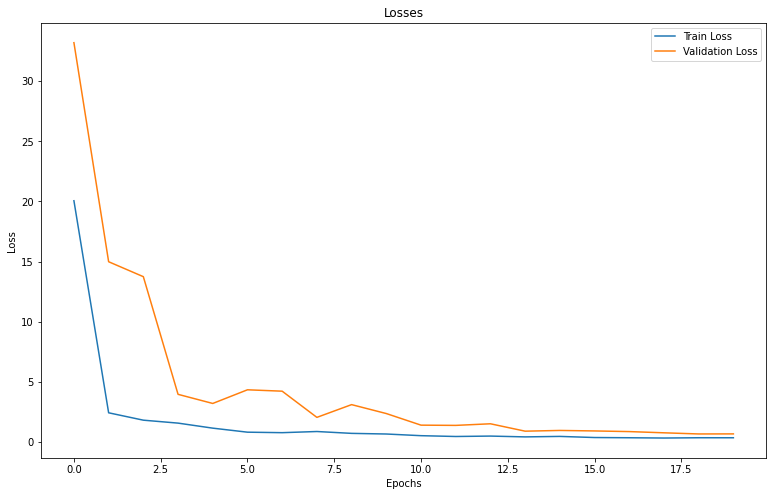

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

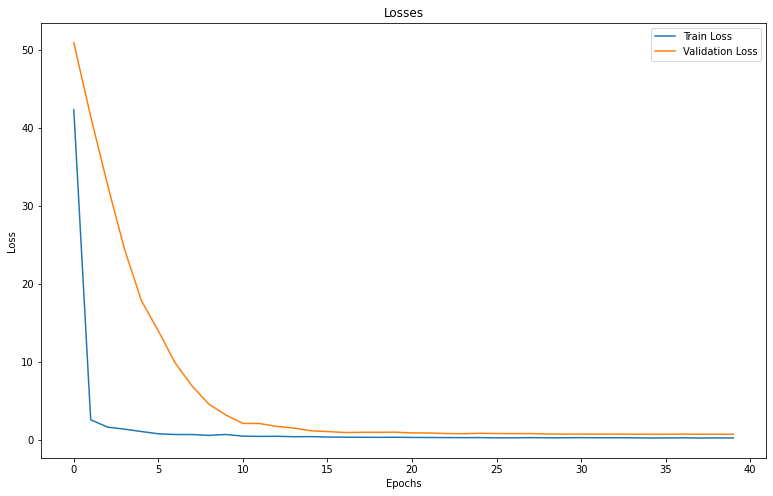

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

tf.Tensor(25, shape=(), dtype=int64)


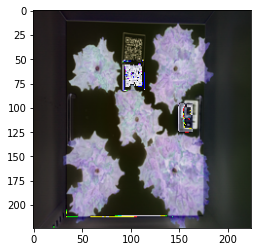

[24.350115]
tf.Tensor(1, shape=(), dtype=int64)


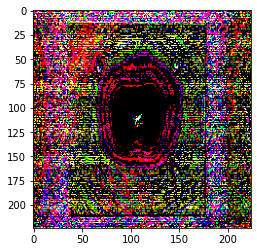

[0.36483225]
tf.Tensor(27, shape=(), dtype=int64)


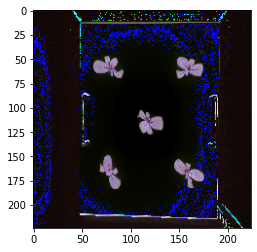

[26.80359]
tf.Tensor(1, shape=(), dtype=int64)


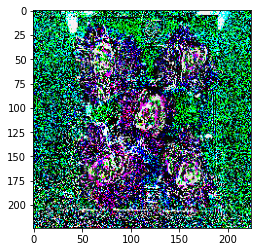

[1.0984935]
tf.Tensor(12, shape=(), dtype=int64)


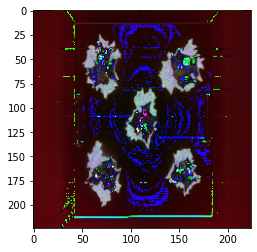

[12.73919]


In [ ]:
for delta, time_delta in train_dataset.take(5):
  print(time_delta[5])
  plt.imshow(delta[5])
  plt.show()

  pred = model.predict(delta)
  print(pred[5])

#pred

In [ ]:
test_set = pd.read_csv('/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/test_data.csv')
test_set['l_root'] = test_set['before_file_path'].map(lambda x: '/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/' + x.split('_')[1] + '/' + x.split('_')[2])
test_set['r_root'] = test_set['after_file_path'].map(lambda x: '/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/' + x.split('_')[1] + '/' + x.split('_')[2])
test_set['l_path'] = test_set['l_root'] + '/' + test_set['before_file_path'] + '.png'
test_set['r_path'] = test_set['r_root'] + '/' + test_set['after_file_path'] + '.png'

In [ ]:
test_set.head()

,idx,before_file_path,after_file_path,l_root,r_root,l_path,r_path
0,0,idx_LT_1003_00341,idx_LT_1003_00154,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
1,1,idx_LT_1003_00592,idx_LT_1003_00687,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
2,2,idx_BC_1100_00445,idx_BC_1100_00840,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
3,3,idx_BC_1112_00229,idx_BC_1112_00105,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
4,4,idx_LT_1088_00681,idx_LT_1088_00698,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...


In [ ]:
print(test_set.iloc[0].l_root)
test_set.iloc[0].l_path

/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003


'/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003/idx_LT_1003_00341.png'

In [ ]:
print(test_set.iloc[0].r_root)
test_set.iloc[0].r_path

/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003


'/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003/idx_LT_1003_00154.png'

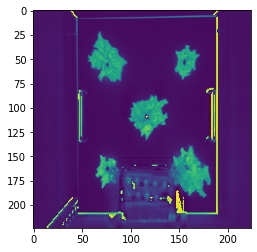

[[20.970018]]


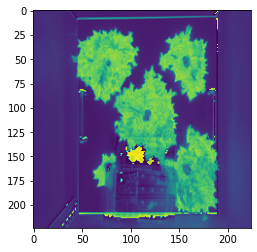

[[23.758072]]


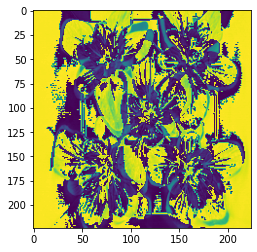

[[2.2284167]]


In [ ]:
for i, v in test_set[:3].iterrows():
  before_image = Image.open(v.l_path)
  before_image = before_image.resize((224, 224))

  after_image = Image.open(v.r_path)
  after_image = after_image.resize((224, 224))

  delta = np.array(before_image) - np.array(after_image)


  delta = tf.reshape(delta, [1, IMG_SIZE, IMG_SIZE])
  delta = tf.cast(delta, tf.float32)/255

  plt.imshow(tf.reshape(delta, [IMG_SIZE, IMG_SIZE]))
  plt.show()

  pred = model.predict(delta)
  print(pred)

  

In [ ]:
cd '/content/drive/MyDrive/dacon_growthperiod/open/works'

/content/drive/MyDrive/dacon_growthperiod/open/works


In [ ]:
pred_res = []
delta_res = []
for i, v in tqdm(test_set.iterrows()):
  before_image = Image.open(v.l_path)
  before_image = before_image.resize((224, 224))

  after_image = Image.open(v.r_path)
  after_image = after_image.resize((224, 224))

  delta = np.array(before_image) - np.array(after_image)
  delta = tf.reshape(delta, [1, IMG_SIZE, IMG_SIZE, 3])
  delta = tf.cast(delta, tf.float32)/255

  delta_res.append(delta)

  pred = model.predict(delta)
  pred_res.append(pred)

3960it [54:55,  1.20it/s]


In [ ]:
import pickle
with open('delta(fliped2).pkl', 'wb') as f:
  pickle.dump(delta, f)

In [ ]:
with open('delta(fliped2).pkl', 'rb') as f:
  delta_res = pickle.load(f)

In [ ]:
len(delta_res)

3960

In [ ]:
model.predict(delta_res[0])

array([[25.375956]], dtype=float32)

In [ ]:
pred_res = []

for d in tqdm(delta_res):
  pred_res.append(model.predict(d))

100%|██████████| 3960/3960 [04:05<00:00, 16.12it/s]


In [ ]:
pred_res[:10]

[array([[27.038494]], dtype=float32),
 array([[29.610779]], dtype=float32),
 array([[5.753618]], dtype=float32),
 array([[3.6360245]], dtype=float32),
 array([[25.702978]], dtype=float32),
 array([[20.383999]], dtype=float32),
 array([[19.353622]], dtype=float32),
 array([[11.57756]], dtype=float32),
 array([[1.3355302]], dtype=float32),
 array([[31.181076]], dtype=float32)]

In [ ]:
ans = [float(p) for p in pred_res]

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/dacon_growthperiod/open/sample_submission.csv')

In [ ]:
sub['time_delta'] = pd.Series(ans)

In [ ]:
sub.head()

,idx,time_delta
0,0,23.287138
1,1,29.795805
2,2,5.994195
3,3,3.681516
4,4,24.720398


In [ ]:
cd '/content/drive/MyDrive/dacon_growthperiod/open/submission'

/content/drive/MyDrive/dacon_growthperiod/open/submission


In [ ]:
sub.set_index('idx', drop=True, inplace=True)

In [ ]:
sub.head()

,time_delta
idx,
0,23.287138
1,29.795805
2,5.994195
3,3.681516
4,24.720398


In [ ]:
sub.to_csv('1216-3.csv')